In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
def integrate2pi(stepper, system, ndots, precision, p, q, s):
    r"""
    Integrate the system, saving only the points at t = 2 \pi k.
    """
    dt = np.pi/precision
    init = [p0, q0]
    
    solpq = np.empty([ndots, *np.shape(init)], dtype=np.float64)
    sols = np.empty(ndots, dtype=np.float64)
    tspan = np.empty(ndots, dtype=np.float64)
    
    t = 0
    for i in range((ndots-1)*2*precision+1):
        if i%(2*precision) == 0:
            idx = i//(2*precision)
            solpq[idx] = [p, q]
            sols[idx] = s
            tspan[idx] = t

        p, q, s, t = stepper(system, dt, p, q, s, t)

    return solpq, sols, tspan

The potential used for the Earth-Moon system can be found in [C90]. The forcing is described in [GEPC17].

In [4]:
cayley_coefficients = {
    -5: [                                                   (7, 15625/129024)  ],
    -4: [                                       (6, 4/45)],
    -3: [                               (5, 81/1280),       (7, 81/2048)       ],
    -2: [                       (4, 1/24),      (6, 7/240)],
    -1: [               (3, 1/48),      (5, 11/768),        (7, 313/30720)     ],
     1: [   (1, -1/2),  (3, 1/16),      (5, -5/384),        (7, -143/18432)    ],
     2: [(0, 1),    (2, -5/2),  (4, 13/16),     (6, -35/288)],
     3: [   (1, 7/2),   (3, -123/16),   (5, 489/128),       (7,-1763/2048)     ],
     4: [           (2, 17/2),  (4, -115/6),    (6, 601/48)],
     5: [               (3, 845/48),    (5, -32525/768),    (7, 208225/6144)   ],
     6: [                       (4, 533/16),    (6, -13827/160)                ],
     7: [                               (5, 228347/3840),   (7, -3071075/18432)],
     8: [                                       (6, 73369/720)],
     9: [                                                   (7, 12144273/71680)]
}

def get_cayely_coefficients(ecc):
    return {
        k: sum(c*ecc**i for (i,c) in v)
        for k,v in cayley_coefficients.items()
    }

class SpinOrbit:
    def __init__(self, ecc, eps, o, l, a=0, mu=0):
        self.ecc = ecc
        self.coeff = get_cayely_coefficients(ecc)
        self.eps = eps
        self.l = l
        self.o = o
        self.a = a
        self.mu = mu
        
        self.pref = lambda t: 1/(1+self.l*np.cos(self.o*t))

    def f(self, t):
        return -self.a-self.l*self.o*np.sin(self.o*t)*self.pref(t)
    
    def V(self, q, t):
        eps = self.eps
        ecc = self.ecc
        return -1/2*eps*self.pref(t)*sum(
                self.coeff[i]*np.cos(2*q - i*t) for i in self.coeff.keys()
            ) - self.mu*q
        
    def Vq(self, q, t):
        eps = self.eps
        ecc = self.ecc
        return eps*self.pref(t)*sum(
                self.coeff[i]*np.sin(2*q - i*t) for i in self.coeff.keys()
              ) - self.mu

# Phase space sections

In what follows we reproduce the phase space section from [GEPC17].

## Periodic moment of intertia in resonance with the orbit

In [5]:
precision = 10
dt = np.pi/precision
ndots = 600

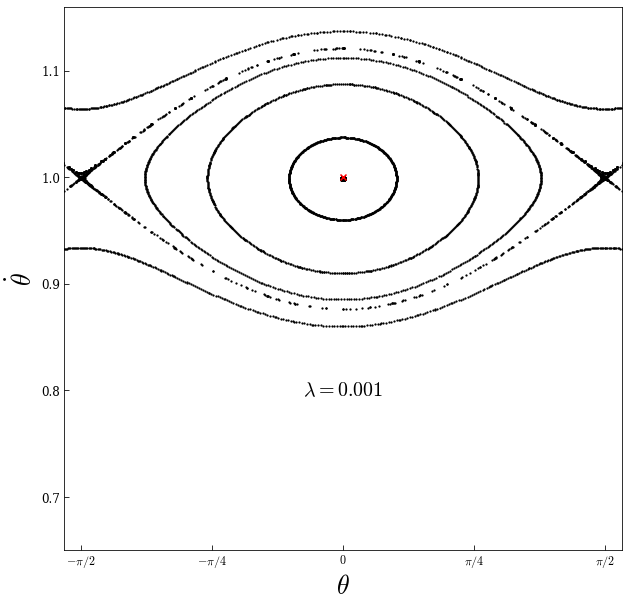

In [6]:
lam = 0.001
em = SpinOrbit(0.01, 0.75*0.01, 1.0, lam)

plt.figure(figsize=(10,10))

#plt.title(f"Spin-orbit, $\\lambda = {lam}$, $dt = {dt:1.3f}$")
plt.text(0, 0.8, f"$\\lambda = {lam}$", fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\dot\\theta$")
plt.xticks(np.linspace(-np.pi/2, np.pi/2,5), ("$-\pi/2$","$-\pi/4$","$0$", "$\pi/4$","$\pi/2$"))
plt.xlim((-0.1-np.pi/2, +0.1+np.pi/2))
plt.ylim((0.65, 1.16))

for (p0, q0) in [(1.137, 0.0),
                 (1.121, 0.0), (1.1209, 0.0),
                 (1.112, 0.0), (1.0, 0.0), (0.96, 0.0), (0.91, 0.0),
                 (0.876375, 0.0),
                 (0.86, 0.0)
                ]:
                #[(p,q) for p in np.linspace(0.9,1.1,10) for q in [np.pi/2, -np.pi/4, 0.0]]:
    # replace ic.step with ic.step6 to us e the 6th order hamiltonian method.
    # Even with the current large timestep, there is no qualitative difference.
    sol, sols_, tspan = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1]+np.pi, 2*np.pi)-np.pi, sol[:,0], s=1.5, c='k')

plt.scatter(0.0, 1.0, c='r', marker='x')

plt.show()

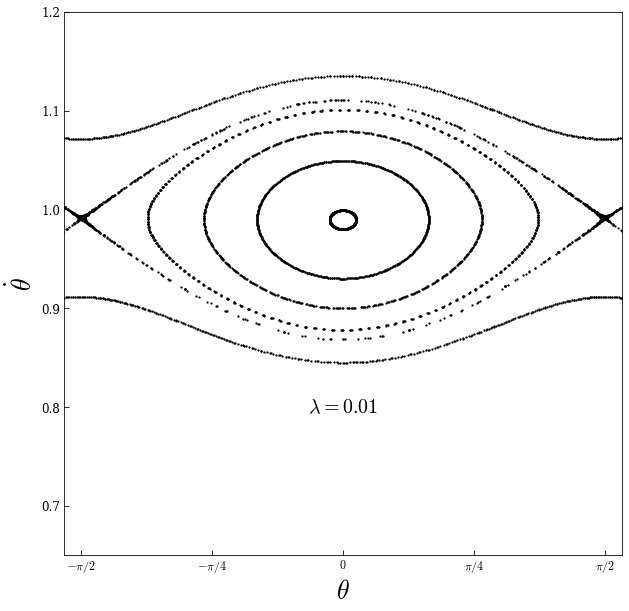

In [7]:
lam = 0.01
em = SpinOrbit(0.01, 0.75*0.01, 1.0, lam)

plt.figure(figsize=(10,10))

#plt.title(f"Spin-orbit, $\lambda = {lam}$, $dt = {dt:1.3f}$")
plt.text(0, 0.8, f"$\\lambda = {lam}$", fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\dot\\theta$")
plt.xticks(np.linspace(-np.pi/2, np.pi/2,5), ("$-\pi/2$","$-\pi/4$","$0$", "$\pi/4$","$\pi/2$"))
plt.xlim((-0.1-np.pi/2, +0.1+np.pi/2))
plt.ylim((0.65, 1.2))

for (p0, q0) in [(1.135, 0.0),
                 (1.1106, 0.0),
                 (0.98, 0.0), (0.93, 0.0), (0.9, 0.0), (0.878, 0.0),
                 (0.86838, 0.0),
                 (0.845, 0.0)
                ]:
                #[(p,q) for p in np.linspace(0.84,1.14,12) for q in [np.pi/2, -np.pi/4, 0.0]]:
    # replace ic.step with ic.step6 to use the 6th order hamiltonian method.
    # Even with the current large timestep, there is no qualitative difference.
    sol, sols_, tspan = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1]+np.pi, 2*np.pi)-np.pi, sol[:,0], s=1.5, c='k')

plt.show()

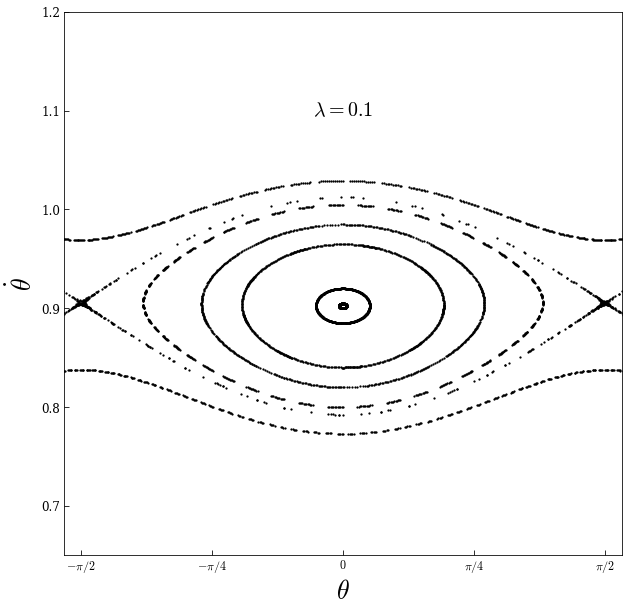

In [8]:
lam = 0.1
em = SpinOrbit(0.01, 3/4*0.01, 1, lam)

plt.figure(figsize=(10,10))

#plt.title(f"Spin-orbit, $\lambda = {lam}$, $dt = {dt:1.3f}$")
plt.text(0, 1.1, f"$\\lambda = {lam}$", fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\dot\\theta$")
plt.xticks(np.linspace(-np.pi/2, np.pi/2,5), ("$-\pi/2$","$-\pi/4$","$0$", "$\pi/4$","$\pi/2$"))
plt.xlim((-0.1-np.pi/2, +0.1+np.pi/2))
plt.ylim((0.65, 1.2))

for (p0, q0) in [(1.029, 0.0),
                 (0.8, 0.0), (0.82, 0.0), (0.84, 0.0), (0.9, 0.0), (0.92, 0.0),
                 (0.79235, 0.0),
                 (0.773, 0.0)
                ]:
                #[(p,q) for p in np.linspace(0.8,1.0,10) for q in [np.pi/2, -np.pi/4, 0.0]]:
    # replace ic.step with ic.step6 to use the 6th order hamiltonian method.
    # Even with the current large timestep, there is no qualitative difference.
    sol, sols_, tspan = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1]+np.pi, 2*np.pi)-np.pi, sol[:,0], s=1.5, c='k')

plt.show()

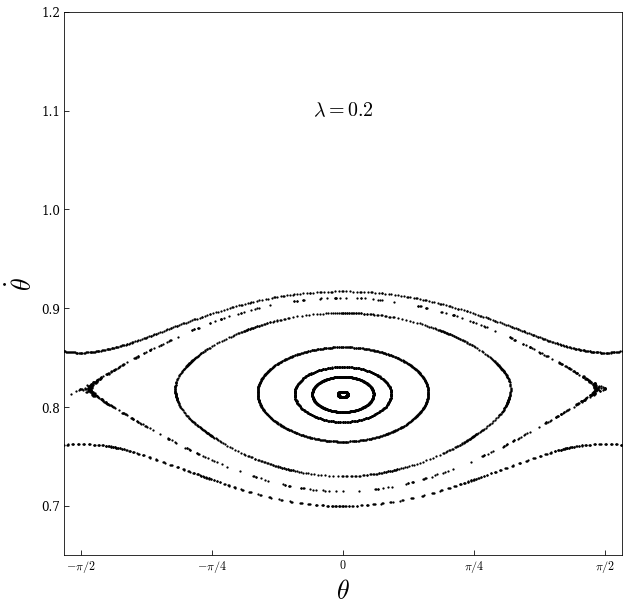

In [9]:
lam = 0.2
em = SpinOrbit(0.01, 3/4*0.01, 1, lam)

plt.figure(figsize=(10,10))

#plt.title(f"Spin-orbit, $\lambda = {lam}$, $dt = {dt:1.3f}$")
plt.text(0, 1.1, f"$\\lambda = {lam}$", fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\dot\\theta$")
plt.xticks(np.linspace(-np.pi/2, np.pi/2,5), ("$-\pi/2$","$-\pi/4$","$0$", "$\pi/4$","$\pi/2$"))
plt.xlim((-0.1-np.pi/2, +0.1+np.pi/2))
plt.ylim((0.65, 1.2))

for (p0, q0) in [(0.917, 0.0),
                 (0.81, 0.0), (0.795, 0.0), (0.785, 0.0), (0.765, 0.0), (0.73, 0.0),
                 (0.7147, 0.0),
                 (0.7, 0.0)
                ]:
                #[(p,q) for p in np.linspace(0.7,0.9,10) for q in [np.pi/2, -np.pi/4, 0.0]]:
    # replace ic.step with ic.step6 to use the 6th order hamiltonian method.
    # Even with the current large timestep, there is no qualitative difference.
    sol, sols_, tspan = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1]+np.pi, 2*np.pi)-np.pi, sol[:,0], s=1.5, c='k')

plt.show()

## Periodic moment of intertia, non-resonant with the orbit

In [10]:
theta = np.sqrt(2)
ndots = 50

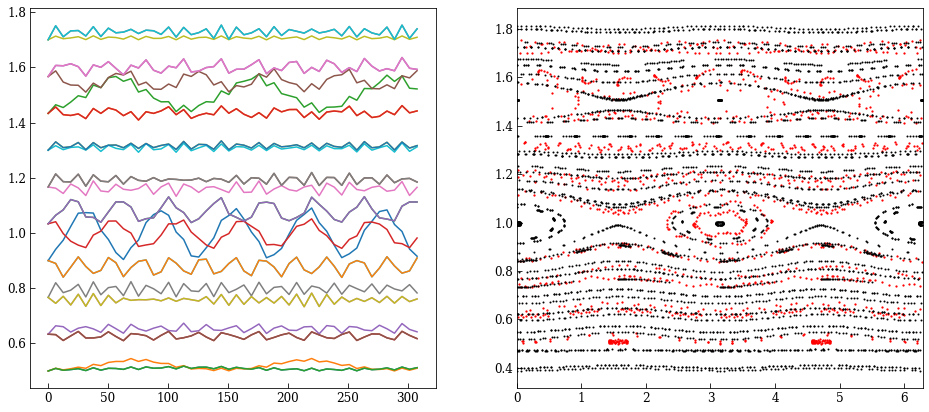

In [11]:
lam = 0.01
base = lambda l: SpinOrbit(0.1, 3/4*0.01, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

#axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))

for (p0, q0) in [(p,q) for p in np.linspace(0.5,1.7,10) for q in [np.pi/2, np.pi, 3*np.pi/2]]:
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,20) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

plt.show()

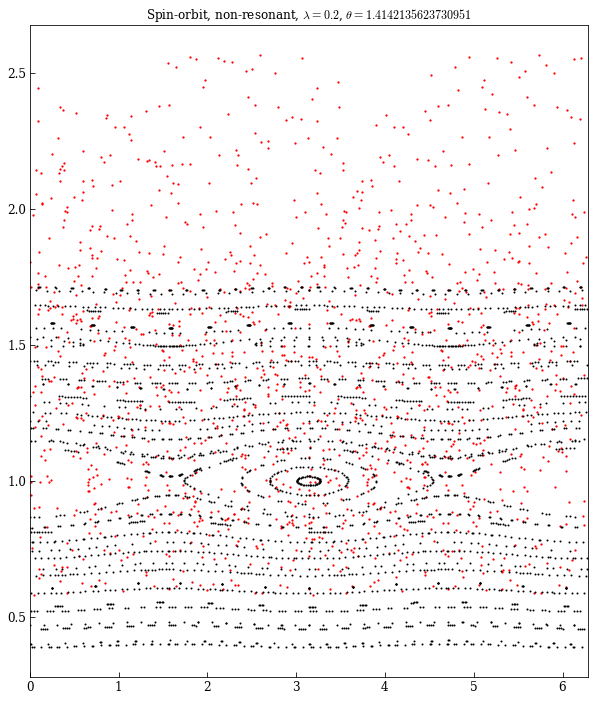

In [12]:
lam = 0.2
em = SpinOrbit(0.01, 3/4*0.01, theta, lam)

plt.figure(figsize=(10,12))

for (p0, q0) in [(p,q) for p in np.linspace(0.6,1.7,10) for q in [np.pi/2, np.pi, 3*np.pi/2]]:
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')

em_nc = SpinOrbit(0.01, 3/4*0.01, theta, 0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.7,20) for q in [np.pi/2, np.pi, 3*np.pi/2]]:
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    plt.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')
    
plt.title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
plt.xlim((0., 2*np.pi))
plt.show()

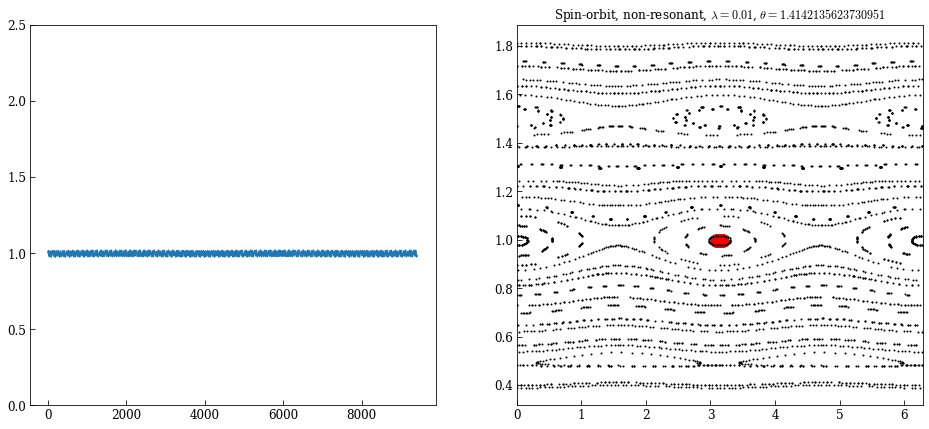

In [13]:
lam = 0.01
base = lambda l: SpinOrbit(0.1, 3/4*0.01, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))
axl.set_ylim((0,2.5))

for (p0, q0) in [(1.0, np.pi)]:
    ndots_ = 1500
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots_, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,18) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    ndots_ = 250
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

plt.show()

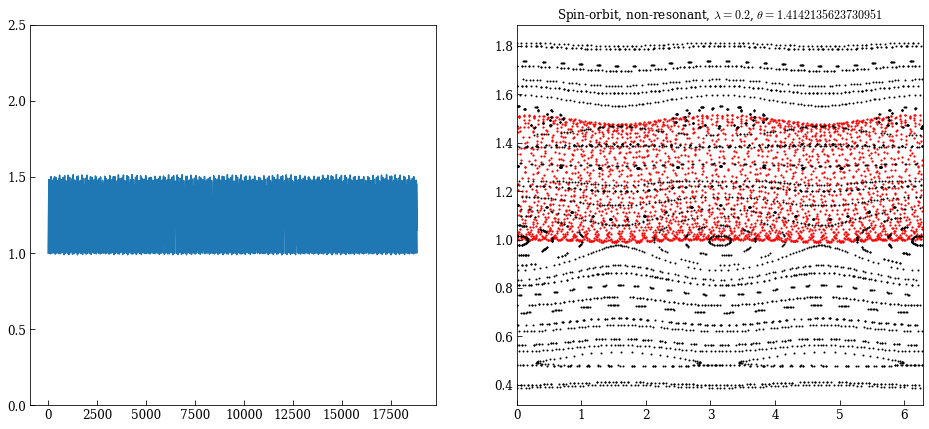

In [14]:
lam = 0.2
base = lambda l: SpinOrbit(0.1, 3/4*0.01, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))
axl.set_ylim((0,2.5))

for (p0, q0) in [(1.0, np.pi)]:
    ndots_ = 3000
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots_, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,18) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    ndots_ = 250
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

#axr.set_ylim((0.38, 1.82))
plt.show()

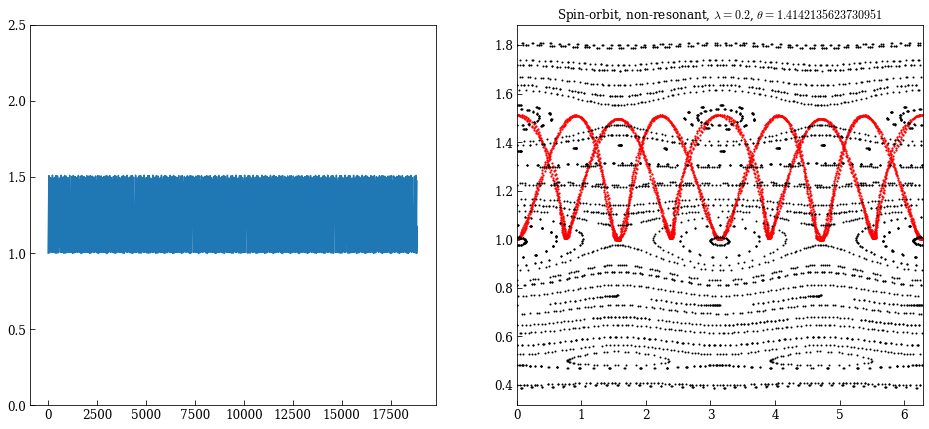

In [15]:
lam = 0.2
base = lambda l: SpinOrbit(0.2, 3/4*0.01, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))
axl.set_ylim((0,2.5))

for (p0, q0) in [(1.0, np.pi)]:
    ndots_ = 3000
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots_, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,18) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    ndots_ = 250
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

#axr.set_ylim((0.3, 1.9))
plt.show()

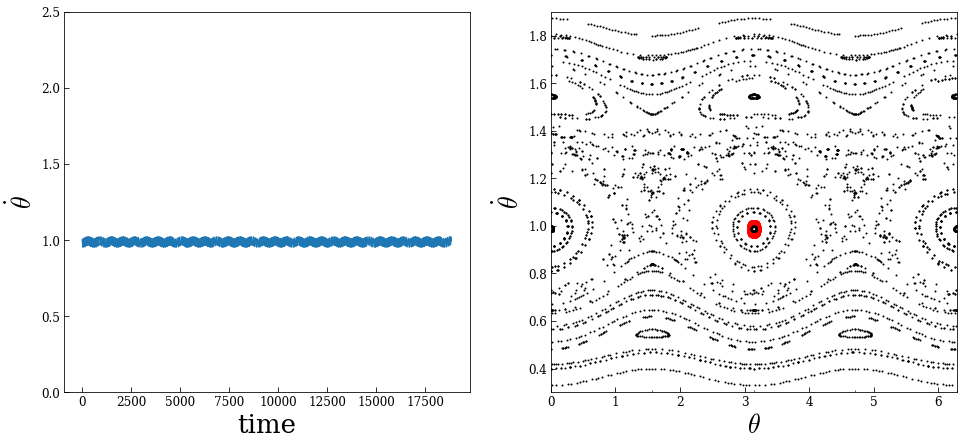

In [16]:
lam = 0.01
base = lambda l: SpinOrbit(0.06, 3/4*0.06, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

axl.set_ylim((0,2.5))
axl.set_xlabel("time")
axl.set_ylabel("$\\dot\\theta$")

#axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))
axr.set_ylim((0.3, 1.9))
axr.set_xlabel("$\\theta$")
axr.set_ylabel("$\\dot\\theta$")
axr.set_xticks(np.linspace(0, 2*np.pi, 5), ("$0$","$\pi/2$","$\pi$","$3\pi/2$","$2\pi$"))

for (p0, q0) in [(1.0, np.pi)]:
    ndots_ = 3000
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots_, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,18) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    ndots_ = 250
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

plt.show()

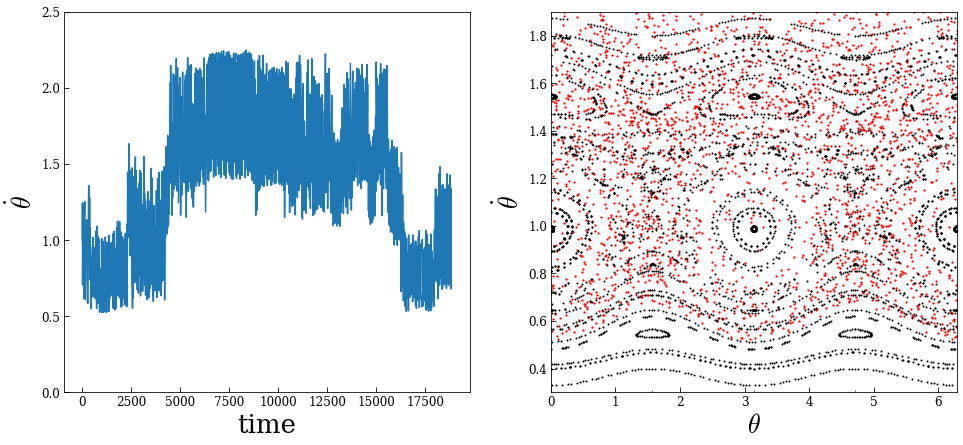

In [17]:
lam = 0.2
base = lambda l: SpinOrbit(0.06, 3/4*0.06, theta, l)
em = base(lam)

fig = plt.figure(figsize=(16,7))

axl = fig.add_subplot("121")
axr = fig.add_subplot("122")

axl.set_ylim((0,2.5))
axl.set_xlabel("time")
axl.set_ylabel("$\\dot\\theta$")

#axr.set_title(f"Spin-orbit, non-resonant, $\\lambda = {lam}$, $\\theta = {theta}$")
axr.set_xlim((0., 2*np.pi))
axr.set_xlabel("$\\theta$")
axr.set_ylabel("$\\dot\\theta$")
axr.set_xticks(np.linspace(0, 2*np.pi, 5), ("$0$","$\pi/2$","$\pi$","$3\pi/2$","$2\pi$"))

for (p0, q0) in [(1.0, np.pi)]:
    ndots_ = 3000
    sol, sols_, tspan_ = integrate2pi(ic.step, em, ndots_, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1.5, c='r')
    axl.plot(tspan_, sol[:,0])

em_nc = base(0)
for (p0, q0) in [(p,q) for p in np.linspace(0.4,1.8,18) for q in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]]:
    ndots_ = 250
    sol, sols_, tspan_ = integrate2pi(ic.step, em_nc, ndots, precision, p0, q0, 0.0)
    axr.scatter(np.mod(sol[:,1], 2*np.pi), sol[:,0], s=1, c='k')

axr.set_ylim((0.3, 1.9))
plt.show()

# Capture into synchronous resonance

In [18]:
lam = 0.0001
em = SpinOrbit(0.01, 3/4*0.01, 1, lam, a = -0.001, mu = 0.001)
precision = 10
dt = np.pi/precision
tf = 10000

plot_every = 20
full = int(np.floor(tf/dt))

npts = int(np.floor(full/plot_every))+1

sol = np.empty([npts, 3], dtype=np.float64)
tspan = np.empty(npts, dtype=np.float64)

p0, q0 = 3, 2.7
p, q, s, t = p0, q0, 0 , 0

for i in range(full):
    if i%plot_every == 0:
        sol[i//plot_every] = [p, q, s]
        tspan[i//plot_every] = t

    p, q, s, t = ic.step(em, dt, p, q, s, t)

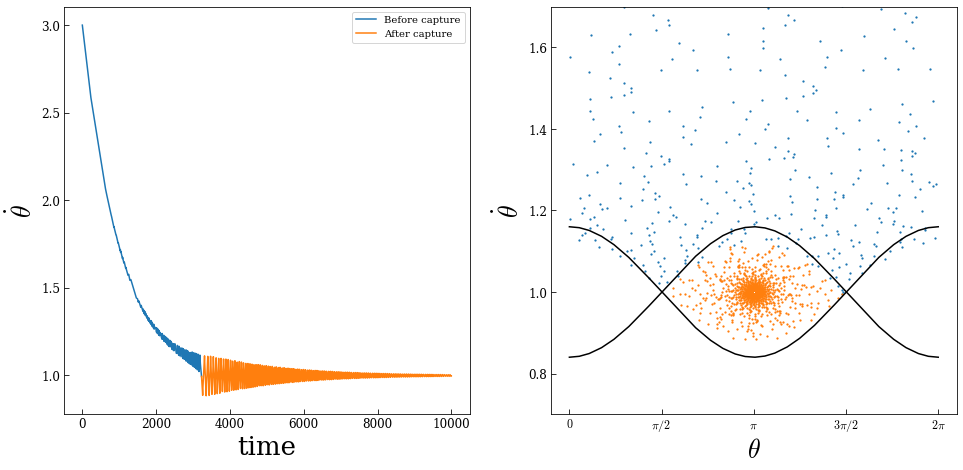

In [19]:
plt.figure(figsize=(16,7.5))
#plt.suptitle(f"$(p_0,q_0)=({p0},{q0})$, $\lambda={lam}$")

cut = -1077
plt.subplot(121)
plt.plot(tspan[:cut], 
         sol[:cut,0],
         label="Before capture")
plt.plot(tspan[cut-1:], 
         sol[cut-1:,0],
         label="After capture")
plt.legend()
plt.xlabel("time")
plt.ylabel("$\\dot\\theta$")

plt.subplot(122)
plt.scatter(
    np.mod(sol[:cut,1], 2*np.pi), 
    sol[:cut,0],
    label="Before capture", s=1.5
)
plt.scatter(
    np.mod(sol[cut-1:,1], 2*np.pi), 
    sol[cut-1:,0],
    label="After capture", s=1.5
)

x = np.linspace(0,2*np.pi,150)
plt.plot(x, 0.16*np.cos(x)+1, 'k')
plt.plot(x, -0.16*np.cos(x)+1, 'k')

#plt.axvline(x=np.pi/2)
#plt.axvline(x=3*np.pi/2)
plt.xlabel("$\\theta$")
plt.ylabel("$\\dot\\theta$")

plt.xticks(np.linspace(0, 2*np.pi, 5), ("$0$","$\pi/2$","$\pi$","$3\pi/2$","$2\pi$"))

plt.ylim((0.7,1.7))

plt.show()

## References

[C90] Celletti, A.: "Analysis of resonances in the spin-orbit problem in Celestial Mechanics: The synchronous resonance (Part I)". _ZAMP_ 41 (1990)

[GEPC17] Gkolias I., Efthymiopoulos C., Pucacco G., Celletti, A.: "Hamiltonian formulation of the spin-orbit model with time-varying non-conservative forces". Comm. Nonlinear Sci. Numer. Simulat. 51 (2017)